In [1]:
!pip install --no-index --find-links="/kaggle/input/surface-package-scraper" -q pytorch_lightning monai albumentations imagecodecs --no-deps # "numpy==1.26.4" "scipy==1.15.3"
!pip uninstall -q -y tensorflow  # preventing AttributeError

In [2]:
# Cell 1
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import gc
import warnings
from typing import Tuple, Optional, Dict, List, Callable
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import os
warnings.filterwarnings("ignore")

images_path = "/kaggle/input/vesuvius-surface-npz/train_images"
mask_path = "/kaggle/input/vesuvius-surface-npz/train_labels"
root_dir = "/kaggle/input/vesuvius-surface-npz"
test_images_path = "/kaggle/input/vesuvius-challenge-surface-detection/test_images"
OUTPUT_DIR = "/kaggle/working/checkpoints"
os.makedirs(OUTPUT_DIR, exist_ok=True)
gc.collect()

30

In [4]:
class Config:
    def __init__(self):
        self.lr = 1e-4
        self.num_workers = 2
        self.batches = 1
        self.val_split = 0.2
        self.target_shape = (128,128,128)
        self.weight_decay = 2e-4
        self.max_epochs = 50
        

config = Config()

In [5]:
import torch
from torch.utils.data import Dataset
import numpy as np
from pathlib import Path
import tifffile
import pytorch_lightning as pl
import random
from monai import transforms as MT
class VesuviusDataset(Dataset):
    def __init__(self, 
                 images_id: list, 
                 images_dir: str = images_path, 
                 test_dir: str = test_images_path,   
                 masks_dir: str = mask_path, 
                 mode: str = "train"):
        
        self.images_id = images_id
        self.mode = mode
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir) if masks_dir else None
        self.test_dir = Path(images_dir) if test_dir else None

    def __len__(self):
        return len(self.images_id)

    def __getitem__(self, idx):
        file_name = self.images_id[idx]
        
        # 1. Determine Source Directory
        if self.mode == "test":
            if self.test_dir is None:
                raise ValueError("Mode is 'test' but no 'test_dir' was provided!")
            source_dir = self.test_dir
        else:
            # Both 'train' and 'val' come from the training images directory
            source_dir = self.images_dir

        # 2. Load Image
        img_path = source_dir / file_name
        img = self.load_volume(img_path)

        # 3. Load Mask (For both Train AND Val)
        if self.mode in ["train", "val"]:
            if self.masks_dir is None:
                raise ValueError(f"Mode is '{self.mode}' but no 'masks_dir' was provided!")
            
            mask_path = self.masks_dir / file_name
            mask = self.load_volume(mask_path, is_mask=True)
            return img, mask, file_name
            
        # 4. Test mode (No mask)
        else:
            return img, None, file_name

    def load_volume(self, file_path, is_mask=False):
        path_obj = Path(file_path)
        if not path_obj.exists():
            raise FileNotFoundError(f"Could not find file: {path_obj}")
        if path_obj.suffix == ".npz":
            archive = np.load(str(path_obj))
            data = archive[list(archive.files)[0]]
        elif path_obj.suffix in [".tif", ".tiff"]:
            data = tifffile.imread(str(path_obj))
        else:
            data = np.load(str(path_obj))
        tensor = torch.from_numpy(data)

        if not is_mask:
            tensor = tensor.half().div_(255.0).unsqueeze(0)
        else:
            tensor = tensor.long().unsqueeze(0)

        return tensor

In [6]:
import os
images_id = None
for _,_,c in os.walk(images_path):
    images_id = c


In [7]:
def custom_collate(batch):
    return batch
#we want colation on happen on gpu as cpu cant do heavy interpolation
#skipping the collation in dataloader

In [8]:
import pytorch_lightning 
class DesuviusDataModule(pl.LightningDataModule):

    def __init__(self,
                 train_img_dir = images_path,
                 test_img_dir = test_images_path,
                 mask_img_dir = mask_path,
                 num_workers = config.num_workers,
                 batches = config.batches,
                 target_shape = config.target_shape):
        super().__init__()
        self.train_img_dir = train_img_dir
        self.test_img_dir= test_img_dir
        self.mask_img_dir = mask_img_dir
        self.num_workers = num_workers
        self.batches = batches
        self.target_shape = target_shape
        self.val_split = config.val_split

        self.train_dataset = None
        self.test_dataset = None
        self.mask_dataset = None

        self.gpu_augments = MT.Compose([
            MT.Resized(keys=["image", "label"], spatial_size=self.target_shape, mode=["trilinear", "nearest"]),
            MT.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            MT.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            MT.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            MT.RandRotated(keys=["image", "label"], range_x=0.1, range_y=0.1, range_z=0.1, prob=0.3, keep_size=True, mode=["bilinear", "nearest"]),
            MT.RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),
            MT.RandGaussianNoised(keys=["image"], prob=0.3, mean=0.0, std=0.01),
        ])
        # Validation transforms: Just Resize (for image AND label)
        self.val_augments = MT.Compose([
            MT.Resized(keys=["image", "label"], spatial_size=self.target_shape, mode=["trilinear", "nearest"])
        ])
        # Validation transforms for Image ONLY (for test set where labels are None)
        self.val_image_augments = MT.Compose([
            MT.Resized(keys=["image"], spatial_size=self.target_shape, mode=["trilinear"])
        ])

    def setup(self, stage = None):
        random.seed(32)
        all_files = images_id # Assumes images_id is defined globally
        random.shuffle(all_files)
        # Split into train/val
        split_idx = int(len(all_files) * (1 - self.val_split))
        train_files = all_files[:split_idx]
        val_files = all_files[split_idx:]
        print(f"Total files: {len(all_files)}")
        print(f"Train files: {len(train_files)}")
        print(f"Val files: {len(val_files)}")

        # FIX: Use the split files, not the global list
        self.train_dataset = VesuviusDataset(images_id = train_files, mode = "train")
        self.val_dataset = VesuviusDataset(images_id = val_files, mode = "val")

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size = self.batches,
            shuffle = True,
            num_workers = self.num_workers,
            pin_memory = True,
            persistent_workers=bool(self.num_workers > 0),
            collate_fn = custom_collate
        )
    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            self.val_dataset,
            batch_size = self.batches,
            shuffle = False, # FIX: Should be False for validation
            num_workers = self.num_workers,
            pin_memory = True,
            persistent_workers=bool(self.num_workers > 0),
            collate_fn = custom_collate
        )

    def on_after_batch_transfer(self, batch, dataloader_idx): 
        if not isinstance(batch, list):
            return super().on_after_batch_transfer(batch, dataloader_idx)

        x_list, y_list, frag_ids = [], [], [] # FIX: renamed z_list to frag_ids
        
        # Determine device
        device = self.trainer.strategy.root_device if self.trainer else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        for item in batch:
            x, y, frag_id = item
            x = x.to(device, non_blocking=True)
            
            # Logic: If we are training, use gpu_augments. 
            # If validating and y exists, use val_augments.
            # If y is None (predict), use val_image_augments.
            
            if y is not None:
                y = y.to(device, non_blocking=True)
                data = {"image": x, "label": y}
                
                # Pick transform
                if self.trainer.training:
                    trans = self.gpu_augments
                else:
                    trans = self.val_augments
                
                data = trans(data) # FIX: Use selected transform
                y_list.append(data["label"])
            else:
                # Prediction case (No Label)
                data = {"image": x}
                trans = self.val_image_augments
                data = trans(data)
                # Do not append to y_list
            
            x_list.append(data["image"])
            frag_ids.append(frag_id)

        # Handle Y stack (if empty)
        y_stack = torch.stack(y_list) if len(y_list) > 0 else None
        
        return torch.stack(x_list), y_stack, frag_ids # FIX: Return list frag_ids

In [9]:
dataModule = DesuviusDataModule()
dataModule.setup()

Total files: 806
Train files: 644
Val files: 162


In [10]:
print(dataModule.train_dataloader)

<bound method DesuviusDataModule.train_dataloader of <__main__.DesuviusDataModule object at 0x7ba6d9d75f50>>


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from monai.losses import TverskyLoss

class surfaceSegementation(pl.LightningModule):
    def __init__(self, net, learning_rate=1e-3, weight_decay=1e-4):
        super().__init__()
        # Fixed typo: save_hyperparameters
        self.save_hyperparameters(ignore=["net"])
        # Fixed: assigned 'net' instead of undefined 'model'
        self.net_module = net
        # Fixed: removed undefined 'config' object and used init args
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.out_channels = 2
        self.spatial_dims  = 3
        self.ignore_index_val = 2
        
        self.crossEntropy = nn.CrossEntropyLoss(
            ignore_index = self.ignore_index_val
        )
        self.Tversky = TverskyLoss(
            softmax = True,
            to_onehot_y = False,
            include_background = True,
            alpha = 0.75,
            beta = 0.25  
        )

    # Added missing forward method required for self(img)
    def forward(self, x):
        return self.net_module(x)

    def _compute_loss(self, logits, targets):
        # pytorch cross entropy can ignore classes inherintly
        targets = targets.squeeze(1)
        ce_loss = self.crossEntropy(logits, targets.long())
        
        # mask so tversky doesnt get confused by class 2 as it cant ignore it natively
        # Fixed: Changed 'target' to 'targets'
        mask = (targets != self.ignore_index_val)
        
        # setting index 2 to 0
        # Fixed: Changed 'target' to 'targets'
        target_clean = torch.where(mask, targets, torch.tensor(0, device=targets.device))
        
        targets_onehot = torch.nn.functional.one_hot(
            target_clean.long(),
            num_classes=2
        ).float()

        # Fixed: Changed self.hparams.spatial_dims to self.spatial_dims
        if self.spatial_dims == 3:
            targets_onehot = targets_onehot.permute(0,4,1,2,3)
        else:
            targets_onehot = targets_onehot.permute(0,3,1,2) # Fixed permute for 2D
        
        # CHANGED: .half() -> .float() to prevent runtime errors on standard FP32 training
        targets_masked_ohe = targets_onehot * mask.unsqueeze(1).float() 

        tversky_loss = self.Tversky(logits, targets_masked_ohe)

        return 0.5*tversky_loss + 0.5*ce_loss

    def _compute_metrics(self, preds_logits: torch.Tensor, targets_class_indices: torch.Tensor) -> dict:
        """
        Computes Dice and IoU fully vectorized (No for-loops).
        """
        num_classes = preds_logits.shape[1]
        preds_hard = torch.argmax(preds_logits, dim=1, keepdim=True)
        valid_mask = (targets_class_indices != self.ignore_index_val)
        
        # 3. One-Hot Encode Predictions
        preds_ohe = torch.nn.functional.one_hot(
            preds_hard.squeeze(1), 
            num_classes=num_classes
        ).float()
        
        # 4. One-Hot Encode Targets
        targets_clean = torch.where(valid_mask, targets_class_indices, torch.tensor(0, device=targets_class_indices.device))
        
        targets_ohe = torch.nn.functional.one_hot(
            targets_clean.squeeze(1).long(), 
            num_classes=num_classes
        ).float()

        # Fixed: Changed self.hparams.spatial_dims to self.spatial_dims
        if self.spatial_dims == 3:
            preds_ohe = preds_ohe.permute(0, 4, 1, 2, 3)
            targets_ohe = targets_ohe.permute(0, 4, 1, 2, 3)
        else:
            preds_ohe = preds_ohe.permute(0, 3, 1, 2)
            targets_ohe = targets_ohe.permute(0, 3, 1, 2)

        valid_mask_float = valid_mask.float()
        preds_ohe = preds_ohe * valid_mask_float
        targets_ohe = targets_ohe * valid_mask_float

        # Fixed: Changed self.hparams.spatial_dims to self.spatial_dims
        reduce_dims = (0, 2, 3, 4) if self.spatial_dims == 3 else (0, 2, 3)

        intersection = (preds_ohe * targets_ohe).sum(dim=reduce_dims)
        cardinality_pred = preds_ohe.sum(dim=reduce_dims)
        cardinality_target = targets_ohe.sum(dim=reduce_dims)
        
        union_sum = cardinality_pred + cardinality_target

        dice_scores = (2. * intersection + 1e-8) / (union_sum + 1e-8)
        iou_scores = (intersection + 1e-8) / (union_sum - intersection + 1e-8)

        return {
            "dice": dice_scores.mean(),
            "iou": iou_scores.mean()
        }

    # Added 'self' argument
    def training_step(self, batch, batch_idx):
        img, mask, _ = batch
        logits = self(img)
        loss = self._compute_loss(logits, mask)
        # Fixed function name _compute_metric -> _compute_metrics
        # Fixed variable name metric -> metrics (to match logging below)
        metrics = self._compute_metrics(logits, mask)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_dice", metrics["dice"], on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_iou", metrics["iou"], on_step=True, on_epoch=True, prog_bar=True)
        return loss

    # Added 'self' argument
    def validation_step(self, batch, batch_idx):
        img, mask, _ = batch
        logits = self(img)
        loss = self._compute_loss(logits, mask)
        # Fixed function name _compute_metric -> _compute_metrics
        # Fixed variable name metric -> metrics
        metrics = self._compute_metrics(logits, mask)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_dice", metrics["dice"], on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_iou", metrics["iou"], on_step=False, on_epoch=True, prog_bar=True)
        return loss

    # Added 'self' argument and renamed to predict_step
    def predict_step(self, batch, batch_idx):
        img, _, frag_id = batch
        logits = self(img)
        prob = torch.softmax(logits, dim=1)
        classes = torch.argmax(prob, dim=1)
        return {"prediction": classes, "frag_id": frag_id}
        
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            # Fixed MAX_EPOCHS to use self.trainer.max_epochs
            T_max=self.trainer.max_epochs if self.trainer else 100,
            eta_min=1e-6
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch"
            }
        }

In [12]:
from monai.networks.nets import SegResNet, SwinUNETR
net = SwinUNETR(
    in_channels=1,
    out_channels=2,
    feature_size=48,
    use_v2=True,
    drop_rate=0.2,
    attn_drop_rate=0.2,
    dropout_path_rate=0.2,
    use_checkpoint=True
)

net_name = net.__class__.__name__
model = surfaceSegementation(net=net)

In [13]:
checkpoint_path = "/kaggle/input/vesuvius-model/checkpoints/SwinUNETR-epoch=47-val_dice=0.7371.ckpt"

In [14]:
inference_files = []
for inference_file,c,d in os.walk("/kaggle/input/vesuvius-challenge-surface-detection/test_images"):
    inference_files = d
random.seed(32)
all_files = images_id # Assumes images_id is defined globally
random.shuffle(all_files)
        # Split into train/val
split_idx = int(len(all_files) * (1 - config.val_split))
train_files = all_files[:split_idx]
val_files = all_files[split_idx:]
inference_files = [val_files[3]]
print(inference_files)

['1866627733.npz']


In [15]:

model = surfaceSegementation.load_from_checkpoint(
    checkpoint_path, 
    net=net
)

# 3. Prepare for Inference
model.eval()        # Disables dropout/batchnorm updates
model.freeze()      # Sets requires_grad=False to save memory
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("done")

done


In [16]:
test_dataset = VesuviusDataset(inference_files,mode = "test")
img,_,_ = test_dataset.__getitem__(0)
img.shape

torch.Size([1, 320, 320, 320])

In [17]:
from tqdm.auto import tqdm
import torch.nn.functional as F
import tifffile
from pathlib import Path
import torch

predictions_tif = []


for image, _, frag_id in tqdm(test_dataset, desc="Processing and saving 3D predictions"):
    image_on_device = image.to(model.device)
    processed_data = dataModule.val_image_augments({"image": image_on_device})
    
    inputs_resized = processed_data["image"].unsqueeze(0)

    with torch.no_grad():
        frag_id_list = [frag_id]
        
        # Assuming predict_step handles the device transfer for inputs if needed
        pred_dict = model.predict_step((inputs_resized, None, frag_id_list), 0)
        
        pred_class = pred_dict["prediction"][0] # (D, H, W)

        # Get original shape
        # Verify this path points to a FILE, not a folder, unless it's a multi-file tif structure
        original_shape = (320,320,320)

        # --- CRITICAL FIX ---
        # Move to CPU before resizing to avoid VRAM OOM
        pred_binary = pred_class.float().cpu()
        
        pred_input_tensor = pred_binary.unsqueeze(0).unsqueeze(0)

        pred_restored = F.interpolate(
            pred_input_tensor,
            size=original_shape,
            mode='nearest'
        ).squeeze(0).squeeze(0)

    # Convert to uint8 (0, 1)
    pred_saved = pred_restored.byte().numpy() # already on cpu
    
    # Save to TIFF
    # prediction_tif_name = f"{frag_id}.tif"
    prediction_tif_name = frag_id
    save_path = Path(OUTPUT_DIR) / Path(prediction_tif_name)
    tifffile.imwrite(str(save_path), pred_saved)
    predictions_tif.append(prediction_tif_name)

    # Optional: Clear cache to be safe if you are close to the limit
    torch.cuda.empty_cache()

# Print the shape of the last processed fragment to verify
print(f"Last saved shape: {pred_saved.shape}")

Processing and saving 3D predictions:   0%|          | 0/1 [00:00<?, ?it/s]

Last saved shape: (320, 320, 320)


In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mid_section(volume_3d):
    """
    Plots the middle cross-section of a 3D numpy array along the XY plane (Z-axis slice).
    
    Args:
        volume_3d (np.ndarray): Input 3D array (e.g., shape Z, Y, X)
    """
    if volume_3d.ndim != 3:
        raise ValueError("Input array must be 3-dimensional")
        
    # Get dimensions
    z_dim, y_dim, x_dim = volume_3d.shape
    
    # Calculate mid-point for Z-axis
    z_mid = z_dim // 2
    
    # Extract slice (XY Plane -> Fix Z)
    slice_xy = volume_3d[z_mid, :, :]
    
    # Setup plot (Single figure)
    plt.figure(figsize=(6, 6))
    
    # Plot XY
    plt.imshow(slice_xy, cmap='gray')
    plt.title(f"XY Plane (Z-slice: {z_mid})")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

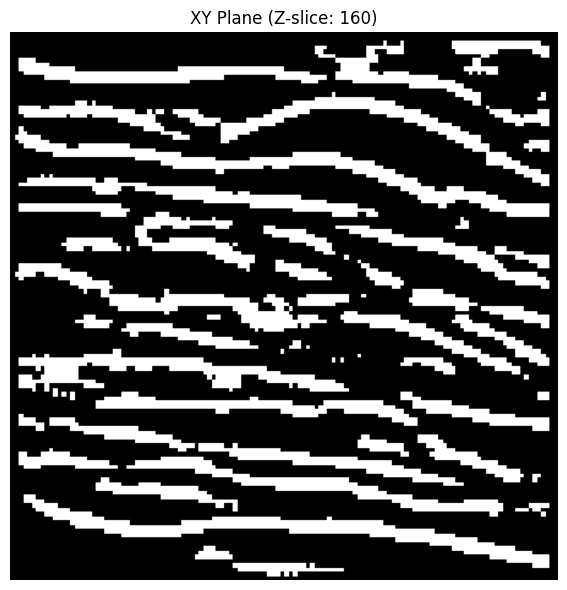

In [21]:
model_output = pred_saved
plot_mid_section(model_output)

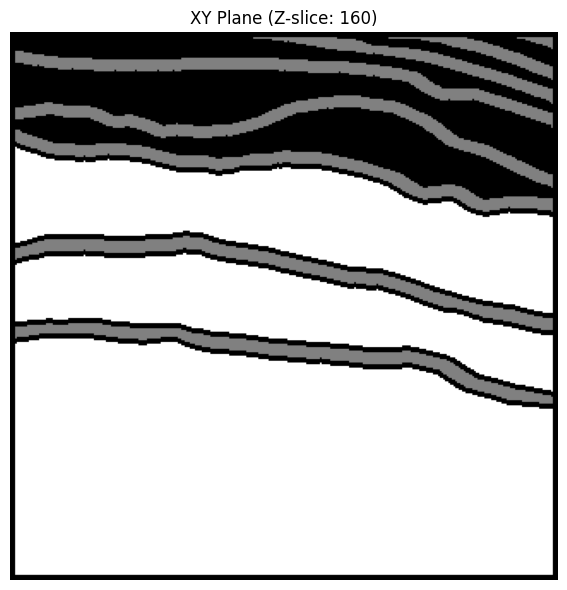

In [27]:
orignal_mask = np.load(f"{mask_path}/1866627733.npz")
plot_mid_section(orignal_mask['arr_0'])

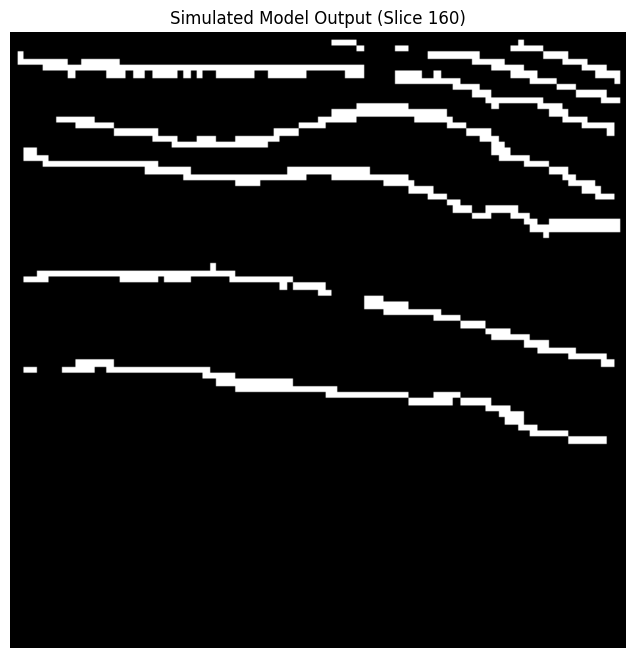

In [45]:
import torch
import torch.nn.functional as F
import numpy as np
from monai import transforms as MT
import matplotlib.pyplot as plt

def erode_mask(mask_tensor, kernel_size=3):

    padding = kernel_size // 2
    # Invert -> MaxPool -> Invert (Standard Morphological Erosion)
    return -F.max_pool2d(
        -mask_tensor, 
        kernel_size=kernel_size, 
        stride=1, 
        padding=padding
    )

def transform_gt_to_model_style(mask_data, 
                                wobble_amount=5.0, 
                                pixelation_factor=0.5,
                                break_intensity=0.7): #

    if isinstance(mask_data, np.ndarray):
        mask_data = torch.from_numpy(mask_data).float()
    if mask_data.ndim == 2:
        mask_data = mask_data.unsqueeze(0)

    binary_mask = (mask_data == 1).float()
    original_size = binary_mask.shape[1:]

    if break_intensity > 0.2:
        binary_mask = erode_mask(binary_mask, kernel_size=3)

    n_holes = int(20 * break_intensity)
    hole_size = int(original_size[0] / 20)

    dropout_transform = MT.RandCoarseDropout(
        holes=n_holes, 
        spatial_size=(hole_size, hole_size), 
        fill_value=0, 
        prob=1.0
    )

    pipeline = MT.Compose([
        # 1. Elastic Deform
        MT.Rand2DElastic(
            prob=1.0,
            spacing=(20, 20),
            magnitude_range=(0, wobble_amount),
            padding_mode="zeros",
            mode="bilinear"
        ),
        dropout_transform,
        # 3. Pixelation (Resize Down -> Resize Up Nearest)
        MT.Resize(
            spatial_size=(int(original_size[0] * pixelation_factor), 
                          int(original_size[1] * pixelation_factor)),
            mode="bilinear" 
        ),
        MT.Resize(
            spatial_size=original_size,
            mode="nearest"
        )
    ])

    output = pipeline(binary_mask)
    
    # Threshold to make it strict binary (0 or 1)
    return (output > 0.5).float()


volume_3d = orignal_mask['arr_0'] 

z_mid = volume_3d.shape[0] // 2
slice_2d = volume_3d[z_mid, :, :]
transformed_slice = transform_gt_to_model_style(
    slice_2d, 
    wobble_amount=5.0, 
    pixelation_factor=0.3,
    break_intensity=0.8 
)

plt.figure(figsize=(8, 8))
plt.title(f"Simulated Model Output (Slice {z_mid})")
plt.imshow(transformed_slice.squeeze(), cmap='gray')
plt.axis('off')
plt.show()